# Overview of MultistageOT for trajectory inference

Load packages:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sbn
import scipy

import sys
sys.path.append("../../../")
from packages.models.multistageot import MultistageOT
import packages.models.tools

In [2]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams.update({'font.size': 16})

Define paths for loading and saving results:

In [3]:
DATA_PATH    = "../../../data/synthetic_data/two_dimensional_data.csv"
RESULTS_PATH = "../../../results/synthetic_data/"
MODEL_PATH   = RESULTS_PATH + "saved_models/two_dimensional_data/"

Import data:

In [4]:
df = pd.read_csv(DATA_PATH, header=None, names=['x','y','class'])

The dataframe has been annotated with "class" numbers, where 0 corresponds to an "initial cell" state, 1 corresponds to an "intermediate cell" state, and the other integers correspond to different classes of terminal cell states.

In [5]:
df.tail(20)

,x,y,class
85,4.25,7.70,1
86,5.00,7.70,1
87,5.75,7.80,1
88,6.30,7.85,1
89,7.10,7.95,1
90,12.10,15.10,5
91,12.50,14.70,5
92,12.35,9.35,4
93,13.30,9.95,4
94,12.80,9.60,4


We thus have:

In [6]:
n_cells_df = pd.DataFrame([df.loc[df['class'] == 0].shape[0],df.loc[df['class'] == 1].shape[0],df.loc[df['class'] > 1].shape[0]], 
            index=['Initial','Intermediate cells','Terminal cells'], columns=['n'])

print('Number of cells of each class:')
n_cells_df

Number of cells of each class:


,n
Initial,3
Intermediate cells,87
Terminal cells,15


For this synthetic data set, we ensure it lies neatly in the unit square:

In [7]:
df[['x','y']] = (df[['x','y']] - df[['x','y']].min()) / (df[['x','y']].max()-df[['x','y']].min()) 

Re-define any cell state that is not intermediate nor initial as "terminal" (denoted by class 2):

In [8]:
df.loc[(df['class'] != 1) & (df['class'] != 0), 'class'] = 2

Here, we use a separate dictionary to keep track of the different fates and the corresponding cell indices:

In [9]:
fates = { "Fate 1" : [90,91], "Fate 2" : [92,93,94], "Fate 3" : [95,96,97,98], "Fate 4" : [99,100,101,102,103,104]}

Plot data

[]

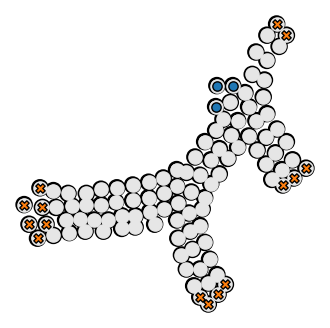

In [78]:
fig, ax = plt.subplots(figsize=(4,4))

size = 90
ax.scatter(df['x'], df['y'], s = 1.25*size, linewidth=2,facecolor='none',edgecolor='k')
ax.scatter(df['x'], df['y'], s=size, color=[0.9,0.9,0.9])
ax.scatter(df.loc[df['class'] == 0]['x'], df.loc[df['class'] == 0]['y'], s =0.5*size, color = 'tab:blue',  edgecolor='k')
ax.scatter(df.loc[df['class'] == 2]['x'], df.loc[df['class'] == 2]['y'], s=0.5*size, color='tab:orange',marker='X', edgecolor='k')

sbn.despine(left=True,bottom=True)

ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

Define the input dataframe with only the coordinates:

In [12]:
input_data = df.iloc[:,:2]

In [13]:
input_data.head()

,x,y
0,0.683983,0.780
1,0.679654,0.705
2,0.740260,0.780
3,0.731602,0.720
4,0.783550,0.755


Define lists of initial- and terminal staes:

In [14]:
initial_cells  = df.loc[df['class'] == 0].index.tolist()
terminal_cells = df.loc[df['class'] == 2].index.tolist()

Initialize model:

In [15]:
msot = MultistageOT(initial_cells   = initial_cells,
                    terminal_cells  = terminal_cells,
                    n_groups        = 10,     # Differentiation stages
                    epsilon         = 0.0125  # Entropy-regularizatioan
                        )

Solve the Multistage problem by calling the fit()-method on the `input_data` DataFrame of "cell data":

In [16]:
msot.fit(input_data,
        verbose   = True, # Print out progression
        patience  = 10,   # Number of iterations between convergence checks
        tolerance = 1e-4  # Tolerance (of iteration update sizes) at which to stop iterating
        )
        
#Save the median cost (for rescaling costs when outliers are added later on)
original_median_cost = msot.median_cost

 Iteration: 470 [========] Max dual step: 1.161e-06 | Infeasibility: 9.015e-05 | Elapsed time: 0:00:00.136836

Sinkhorn algorithm converged to a solution within the given tolerance (1.0000e-04) of both feasibility and max dual-variable update step.


Retrieving transport plans...
Done.
Storing dual variables...
Done.
Max absolute feasibility errors in the marginal constraints: 
  {'mu_0': 0.0, 'mu_sum': 8.251751398791196e-05, 'max_mu_t': 7.72951595570115e-05, 'mu_T': 9.01489845535064e-05}


To reduce the regularization parameter, we can run the proximal Sinkhorn scheme until the regularization (epsilon) parameter is below the epsilon threshold (see Supplementary Note for details):

In [17]:
msot.proximal_sinkhorn(epsilon_threshold=0.006, patience=10)

 [Proximal Sinkhorn] Outer iterations: 2 | Initial epsilon: 1.2500e-02 | Current epsilon: 1.2500e-02 | Total epsilon: 4.1667e-03 | Elapsed time: 0:00:00.444153
 Terminating proximal scheme.


## Saving/loading

The MultistageOT package allows us to save the fitted model:

In [17]:
#msot.save_model(path = MODEL_PATH)

>>> Saving MMOT model...
To:  ../../../results/synthetic_data/saved_models/two_dimensional_data/
Done.


And load the results:

In [32]:
#msot = MultistageOT()
#msot.load_model(path = MODEL_PATH)

<<< Loading MMOT model...
From:  ../../../results/synthetic_data/saved_models/two_dimensional_data/
Done.


Order data according to the partition into initial-, intermediate-, and terminal-cells

In [18]:
df = df.loc[msot.initial_cells + msot.intermediate_cells + msot.terminal_cells]

We can compute the most active stage in transport ('max_group') for each cell:

We can compute the marginals $\mu_1,\dots, \mu_{T-1}$, encoding the total mass transported in each transport stage, for each cell:

In [19]:
mu = msot.marginals()

Summing over these marginals gives us the total amount of mass that passes through each cell during all stages:

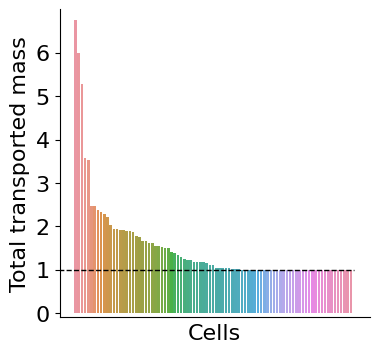

In [20]:
plt.figure(figsize=(4,4))

#Plot bars with total transported mass for each cell:
rank_transported_mass = mu.loc[msot.intermediate_cells].sum(axis=1).sort_values(ascending=False)
sbn.barplot(x=[k for k in range(1,len(msot.intermediate_cells)+1)], y=rank_transported_mass)
plt.hlines(y=1, xmin=-10, xmax=len(msot.intermediate_cells),color='k',linewidth=1, linestyle='dashed')
plt.ylim([-0.1,7])
plt.xlim([-5,None])
plt.yticks([k for k in range(7)])
plt.ylabel('Total transported mass')
plt.xlabel('Cells')
plt.xticks([])
sbn.despine()

Note that cells transport a minimim of 1 unit of mass over all transport stages.

We can compute the most active stage of transport for each cell:

In [21]:
cell_group = msot.max_marginal_groups()

df_max = df.copy()
df_max.loc[mu.index, 'max_stage'] = np.argmax(mu.values,axis=1)+1
df_max.loc[msot.initial_cells, 'max_stage'] = 0
df_max.loc[msot.terminal_cells, 'max_stage'] = 11

print('\n Stage |', '% cells')
100*pd.Series(cell_group).value_counts()/len(msot.intermediate_cells)


 Stage | % cells


3     12.643678
5     12.643678
7     11.494253
9     11.494253
2     10.344828
4      9.195402
6      9.195402
8      8.045977
10     8.045977
1      6.896552
Name: count, dtype: float64

Plot histogram over the most active stage of transport:

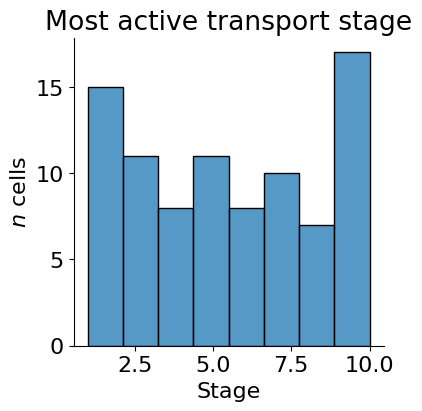

In [22]:
plt.figure(figsize=(4,4))
sbn.histplot(df_max.loc[msot.intermediate_cells,'max_stage'])
plt.title('Most active transport stage')
plt.xlabel('Stage')
plt.ylabel('$n$ cells')
sbn.despine()

([], [])

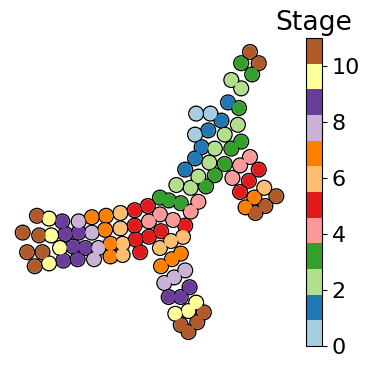

In [23]:
plt.figure(figsize=(4.5,4))

size = 90
plt.scatter(df['x'], df['y'], s=1.25*size,facecolor='none',edgecolor='k')
plt.scatter(df.loc[df['class'] == 0]['x'], df.loc[df['class'] == 0]['y'], color='k')
plt.scatter(df.loc[df['class'] == 2]['x'], df.loc[df['class'] == 2]['y'], color='k')
plt.scatter(df['x'], df['y'], s=size,edgecolor='none',c=df_max['max_stage'], cmap='Paired')
cb = plt.colorbar()
cb.ax.set_title('Stage')
sbn.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])

Instead of fixing a time step to each cell, by looking at its most active transport stage, we can alternatively plot each marginal to see how mass is distributed on the intermediate cells in each stage. For visualization purposes, we normalize each marginal:

In [24]:
mu_df_normed = mu.div(mu.sum(axis=1), axis=0)
df_with_normalized_marginals = pd.concat((df, mu_df_normed), axis=1)

Plot marginals:

0
1
2
3
4
5
6
7
8
9


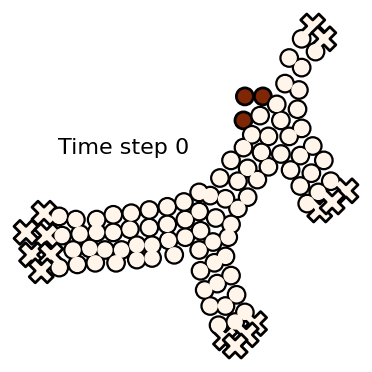

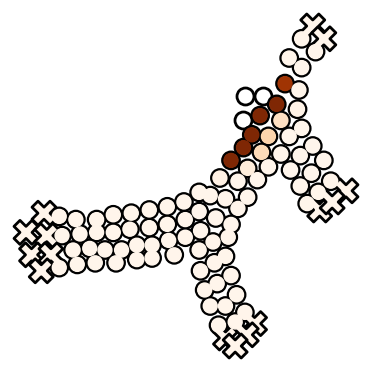

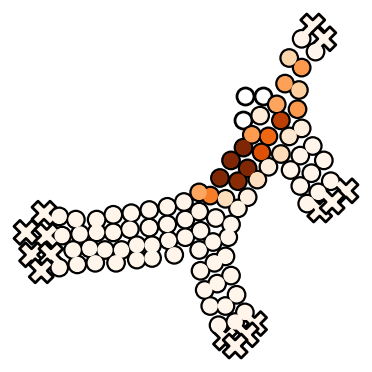

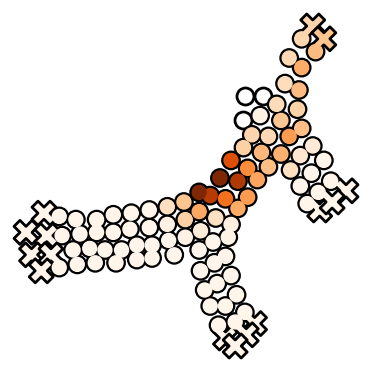

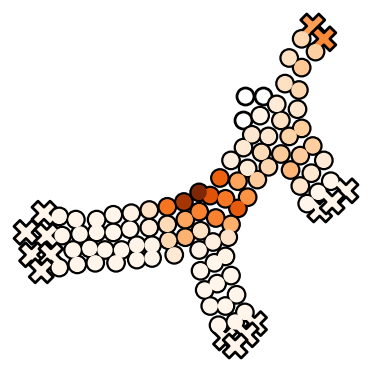

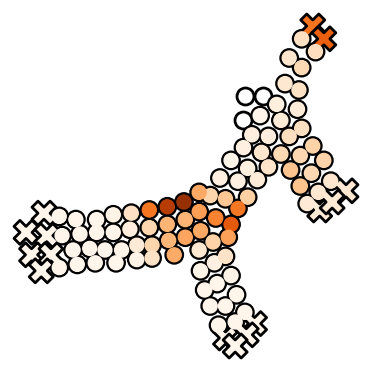

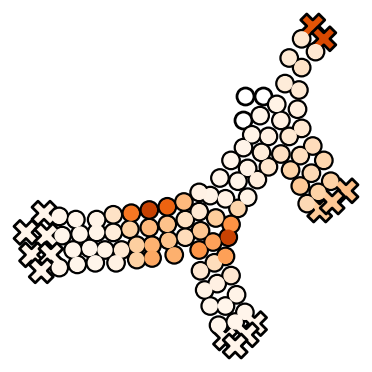

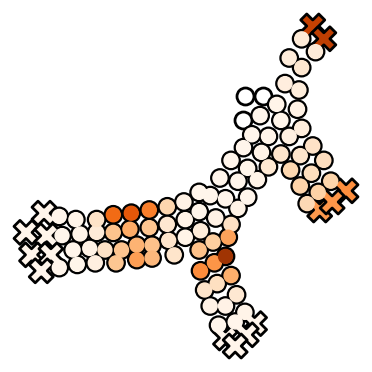

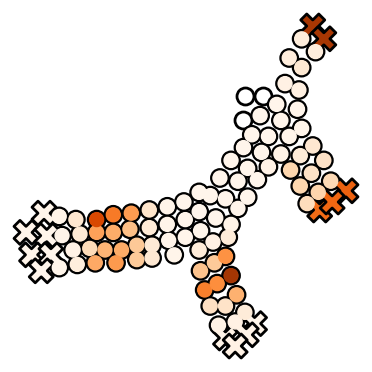

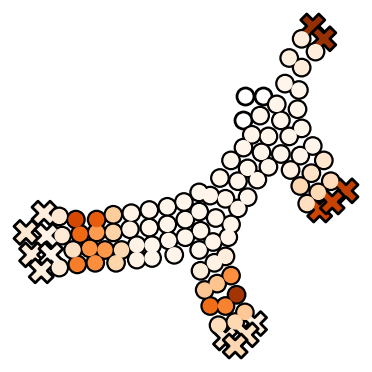

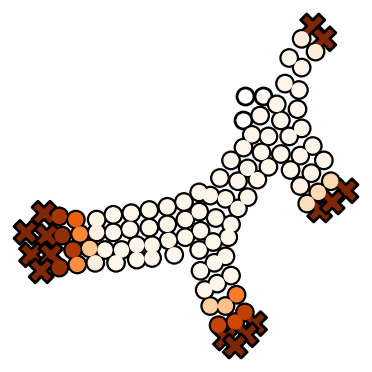

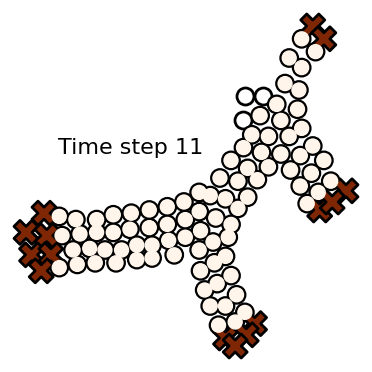

In [25]:
import copy


size = 100
mus = ['mu_{t}'.format(t=t) for t in range(1,11)] 
colormap = 'Oranges'

nu_cumsum = msot.mass_to_terminals().cumsum(axis=1)

fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(df.loc[df['class'] == 0]['x'], df.loc[df['class'] == 0]['y'], s =  1.5*size, c = [1,1,1], cmap=colormap, vmin=0, vmax=1,facecolor='w', linewidth=2, edgecolor='k')
ax.scatter(df.loc[msot.intermediate_cells]['x'], df.loc[msot.intermediate_cells]['y'], s = 1.5*size, linewidth=2,facecolor='none',edgecolor='k')
ax.scatter(df.loc[df['class'] == 2]['x'], df.loc[df['class'] == 2]['y'], s= 3*size, c=0*nu_cumsum.iloc[:,0],vmin=0, vmax=1,cmap=colormap,  marker='X', linewidth=2, edgecolor='k')
ax.scatter(df['x'], df['y'], s=size,c=0*mu[mus[0]], vmax=1,cmap=colormap)

couplings = copy.deepcopy(msot.transport_plans[0])

ax.set_xticks([])
ax.set_yticks([])
ax.text(0.1,0.6, 'Time step 0')
plt.tight_layout()
sbn.despine(left=True, bottom=True)   

cmap_dyn = plt.get_cmap('viridis')
for i in range(len(mus)):
    print(i)
    fig, ax = plt.subplots(figsize=(4,4))


    ax.scatter(df.loc[df['class'] == 0]['x'], df.loc[df['class'] == 0]['y'], s =  1.5*size, facecolor='w', linewidth=2, edgecolor='k')
    ax.scatter(df.loc[msot.intermediate_cells]['x'], df.loc[msot.intermediate_cells]['y'], s = 1.5*size, linewidth=2,facecolor='none',edgecolor='k')
    ax.scatter(df.loc[df['class'] == 2]['x'], df.loc[df['class'] == 2]['y'], s= 3*size, c=nu_cumsum.iloc[:,i],vmin=0, vmax=1,cmap=colormap,  marker='X', linewidth=2, edgecolor='k')
    ax.scatter(df['x'], df['y'], s=size,c=mu[mus[i]], vmax=1,cmap=colormap)

    couplings = copy.deepcopy(msot.transport_plans[i+1])
 

    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    sbn.despine(left=True, bottom=True)   


fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(df.loc[df['class'] == 0]['x'], df.loc[df['class'] == 0]['y'], s =  1.5*size, facecolor='w', linewidth=2, edgecolor='k')
ax.scatter(df.loc[msot.intermediate_cells]['x'], df.loc[msot.intermediate_cells]['y'], s = 1.5*size, linewidth=2,facecolor='none',edgecolor='k')
ax.scatter(df.loc[df['class'] == 2]['x'], df.loc[df['class'] == 2]['y'], s= 3*size, c=nu_cumsum.iloc[:,-1],vmin=0, vmax=1,cmap=colormap,  marker='X', linewidth=2, edgecolor='k')
ax.scatter(df['x'], df['y'], s=size,c=0*mu[mus[i]], vmax=1,cmap=colormap)
ax.set_xticks([])
ax.set_yticks([])
ax.text(0.1,0.6, 'Time step 11')
#ax.set_title(times[i])   
plt.tight_layout()
sbn.despine(left=True, bottom=True)   


Plot some colorbars:

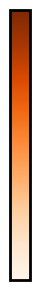

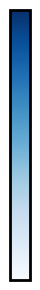

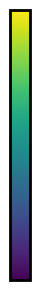

In [26]:
import matplotlib as mpl

fig = plt.figure(figsize=(8, 3))
ax = fig.add_axes([0., 0., 0.025, 0.9])

cb_genes = mpl.colorbar.ColorbarBase(ax, cmap='Oranges', 
                                orientation='vertical')
cb_genes.set_ticks([])
cb_genes.outline.set_linewidth(2)


fig = plt.figure(figsize=(8, 3))
ax = fig.add_axes([0., 0., 0.025, 0.9])

cb_genes = mpl.colorbar.ColorbarBase(ax, cmap='Blues', 
                                orientation='vertical')
cb_genes.set_ticks([])
cb_genes.outline.set_linewidth(2)


fig = plt.figure(figsize=(8, 3))
ax = fig.add_axes([0., 0., 0.025, 0.9])

cb_genes = mpl.colorbar.ColorbarBase(ax, cmap='viridis', 
                                orientation='vertical')
cb_genes.set_ticks([])
cb_genes.outline.set_linewidth(2)


# Pseudotime ordering

Cells take part in transport in different stages. Thus, each cell has a mass distribution over all the stages:

In [27]:
msot.mean_marginal_group()

0      1.199382
1      1.607803
2      1.430310
3      2.488200
4      2.574453
         ...   
100         NaN
101         NaN
102         NaN
103         NaN
104         NaN
Name: mean_marginal_group, Length: 105, dtype: float64

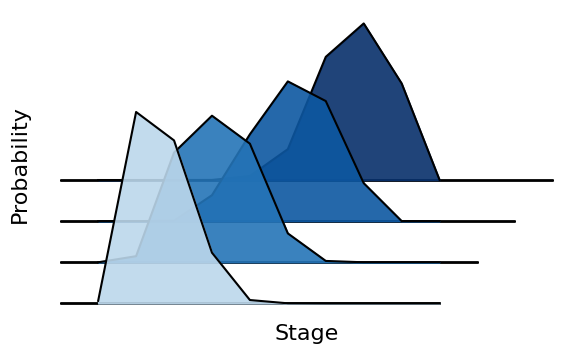

In [28]:
plt.figure(figsize=(7,4))

delta = 0.1
alpha = 0.9
cmap = plt.get_cmap('Blues')
cells = [52, 37, 31, 33]

times = np.array([msot.mean_marginal_group().loc[cell] for cell in cells])
normalized_times = times/ np.max(times)

for i in range(len(cells)):
    
    groups = mu_df_normed.shape[1]
    plt.hlines(y= delta*(i+1)*np.ones(groups), color='k', linewidth=1, xmin=0,xmax=groups+i,zorder=0)
    plt.fill_between(np.linspace(1, groups,groups), delta*(i+1)*np.ones(groups), delta*(i+1)+mu_df_normed.iloc[cells[i],:].values, color=cmap(normalized_times[i]), zorder=100-i,alpha=alpha)
    plt.plot(np.linspace(1, groups,groups),   (i+1)*delta+mu_df_normed.iloc[cells[i],:], linewidth=1.5, color='k', zorder=100-i)
plt.xticks([])
plt.yticks([])
plt.xlabel('Stage')
plt.ylabel('Probability')
sbn.despine(left=True, bottom=True)   


The stage-dependent differences in mass transport can be seen as quantifying how likely a cell is to transition in a given stage. This also provides a natural way of ordering the cells in terms of maturity:

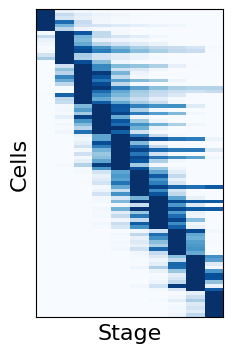

In [29]:
plt.figure(figsize=(5,4)) 
plt.rcParams.update({'font.size': 16})
order = pd.Series(np.argmax(mu_df_normed.iloc[3:-18,:],axis=1),index=mu_df_normed.iloc[3:-18,:].index).sort_values().index
mu_df_max_normed = mu_df_normed.div(mu_df_normed.max(axis=1), axis=0)
plt.imshow(mu_df_max_normed.loc[order], extent=[1,10,74,0], cmap='Blues', aspect=0.2)
plt.yticks([])
plt.xticks([])
plt.ylabel('Cells')
plt.xlabel('Stage')


Finally, we compute "pseudotime" as the mean stage of transport:

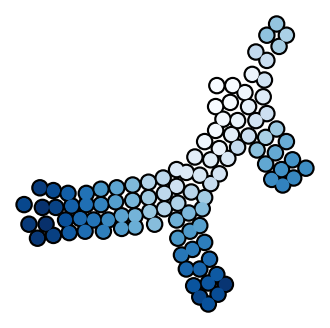

In [30]:
fig, ax = plt.subplots(figsize=(4,4))

size = 90
ax.scatter(df['x'], df['y'], s = 1.25*size, linewidth=2,facecolor='none',edgecolor='k')

ax.scatter(df['x'], df['y'], c=msot.pseudotemporal_order(), s = size, cmap='Blues',edgecolor='none')
ax.set_xticks([])
ax.set_yticks([])

sbn.despine(left=True, bottom=True)   

Compute the marginals $\nu_t$ for $t = 1,\dots,10$ (mass sent to terminals in each stage)

In [31]:
nu_df = msot.mass_to_terminals()

#Normalize:
nu_df_normed = nu_df.div(nu_df.sum(axis=1),axis=0)

We can compute a mean transition time for each terminal cell state, corresponding to the mean stage it receives mass transport from an intermediate cell:

Text(0.5, 0, 'Cells')

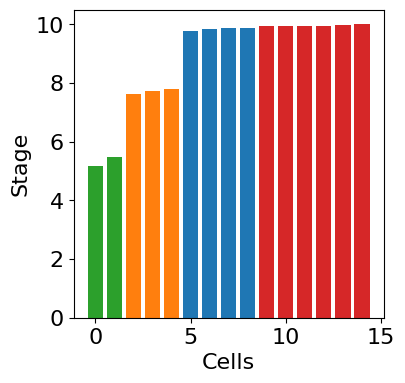

In [32]:
plt.figure(figsize=(4,4))
clrs = plt.get_cmap('tab10')([2,1,0,3])
clrs_series = pd.Series({fates['Fate {k}'.format(k=k+1)][idx] : clrs[k] for k in range(len(fates)) for idx in range(len(fates['Fate {k}'.format(k=k+1)]))})

mean_nu_sorted = (nu_df_normed@np.linspace(1,10,10)).sort_values()
 
plt.bar([k for k in range(len(mean_nu_sorted.values))], mean_nu_sorted.values,color=clrs_series.values)
plt.ylabel('Stage')
plt.xlabel('Cells')

This next plot is just a collapsing of the first, where we compute the mean stage within each fate group:

Text(0, 0.5, 'Mean stage for transitions')

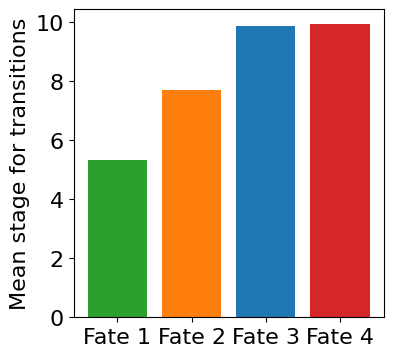

In [33]:
fate_group_mean_nu = [(nu_df_normed@np.linspace(1,10,10)).loc[fates[fate]].mean() for fate in fates]

clrs = plt.get_cmap('tab10')([2,1,0,3])

plt.figure(figsize=(4,4))
plt.bar([fate for fate in fates], fate_group_mean_nu, color=clrs)
plt.ylabel("Mean stage for transitions") 

# Cell fates

Visualize transport plans in different stages (these plans are solutions to the MultistageOT problem and can be interpreted as encoding the likelihood of transitions between cells in each stage):

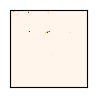

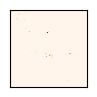

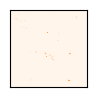

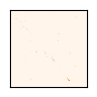

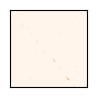

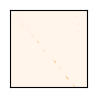

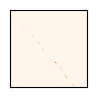

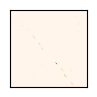

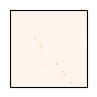

In [34]:
for t in range(len(msot.transport_plans)-2):
    plt.figure(figsize=(1,1))
    plt.imshow(msot.transport_plans[t+1], extent=(0,1,0,1), vmin=0,vmax=1, cmap='Oranges') 
    plt.xticks([])
    plt.yticks([]) 


The transport plans are aggregated into a transition probability matrix, encoding the probability of transitions (in a Markov chain) between any two cells in the data set:

In [35]:
transition_matrix = msot.transition_matrix()

Visualize the transition matrix (the exact visualization of the matrix will of course depends on how the data points are ordered):

([], [])

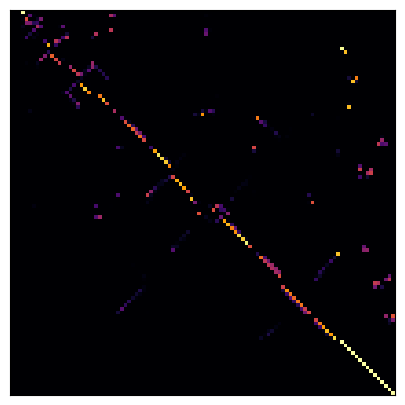

In [36]:
plt.figure(figsize=(5,5))
plt.imshow(transition_matrix, cmap='inferno')
plt.xticks([])
plt.yticks([]) 

Visualization of the matrix in terms of a graph, in which edges are proportional to transition probability:

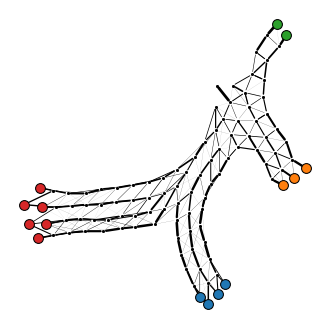

In [37]:
import copy
# Create the scatter plot

fig, ax = plt.subplots(figsize=(4,4))

# Plot couplings:
transition_matrix_approx = copy.deepcopy(transition_matrix)
transition_matrix_approx[transition_matrix_approx<0.01] = 0

scale = 2
size = 50
alpha =  1

clrs = plt.get_cmap('tab10')([2,1,0,3])
packages.models.tools.plot_couplings(ax, transition_matrix_approx, df.values, df.values, 
                color='k', scale=scale, alpha=alpha, scatter_size=1)
[ax.scatter(df.loc[fates['Fate {f}'.format(f=f+1)], 'x'], df.loc[fates['Fate {f}'.format(f=f+1)],'y'], s=50, linewidth=0.75, edgecolor='k', color=clrs[f]) for f in range(len(fates))]

# Show the plot 
sbn.despine(bottom=True,left=True)
plt.xticks([])
plt.yticks([])


Plot transitions for a representative cell:

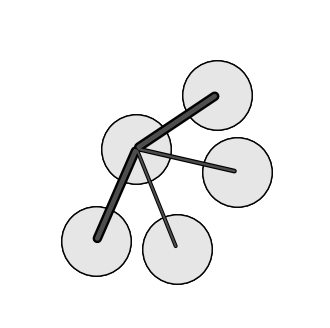

In [38]:
import copy
# Create the scatter plot
fig, ax = plt.subplots(figsize=(4,4))

# Plot couplings:
transition_matrix_df = pd.DataFrame(transition_matrix.copy(), index=msot.initial_cells + msot.intermediate_cells + msot.terminal_cells)

scale = 20
size  = 50
alpha =  1

#Look only at a single example cell:
transition_matrix_df_subset = transition_matrix_df.iloc[3,:] 
x = df.iloc[3,:]
y = df

#Plot only its significant transitions (above 0.001):
receivers = transition_matrix_df_subset.loc[transition_matrix_df_subset > 0.001].index

packages.models.tools.plot_couplings(ax, transition_matrix_df.loc[3,receivers].values[None,:] , df.values[3,:][None,:], df.loc[receivers].values, 
                color='k', scale=scale, alpha=alpha, scatter_size=2500)
packages.models.tools.plot_couplings(ax, transition_matrix_df.loc[3,receivers].values[None,:] , df.values[3,:][None,:], df.loc[receivers].values, 
                color=[0.3,0.3,0.3], scale=0.5*scale, alpha=alpha, scatter_size=2500)
# Show the plot 
sbn.despine(bottom=True,left=True)
plt.xticks([])
plt.yticks([])

# Show the plot 
sbn.despine(bottom=True,left=True)
plt.xticks([])
plt.yticks([])
plt.xlim([0.65,0.85])
plt.ylim([0.61,0.81])


Plot strength of transitions:

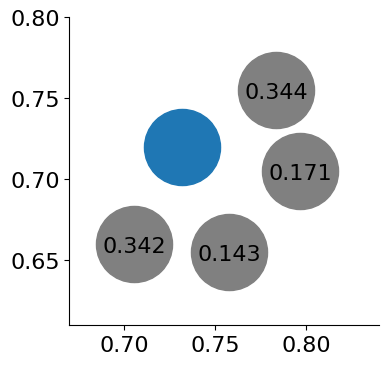

In [39]:
transition_matrix_subset_receivers = transition_matrix_df_subset[receivers]
y_receivers = y.loc[receivers]
x_flat = x

plt.figure(figsize=(4,4))
plt.scatter(x_flat[0],x_flat[1], s=3000)
for cell in receivers:
    plt.scatter(y_receivers.loc[cell, 'x'],y_receivers.loc[cell, 'y'], s=3000,c='grey')
    plt.text(y_receivers.loc[cell, 'x']-0.0175,y_receivers.loc[cell, 'y']-0.005,np.round(transition_matrix_subset_receivers[cell],3))
plt.xlim([0.67,0.84])
plt.ylim([0.61,0.80])
sbn.despine()

Based on the transition probability matrix, we can readily compute cell fate probabilities by viewing the transition probabilities in terms of a stationary absorbing Markov chain and computing absorption probabilities to each fate group. 

In [40]:
help(MultistageOT.cell_fate_probabilities)

Help on function cell_fate_probabilities in module packages.models.multistageot:

cell_fate_probabilities(self, fate_groups=None, transition_matrix=None)
    Compute cell fate probabilities as the absorption probabilities in a Markov chain model
    based on the optimal transport plans.
    
    Parameters:
    ----------
    fate_groups   : dict
                    dictionary of key:value pairs of the form <fate_label> : <index_array>, where <fate_label> is a name (string) of
                    a terminal fate (i.e., 'erythroid'), and <index_array> is the indices corresponding to that class of cells.
    
    transition_matrix (optional) : numpy array
                                   Pre-computed N x N matrix (N = number of cells in the snapshot) of elements t_{ij}, encoding the transition probabilities
                                   between every cell i and every other cell j in the snapshot.
    Returns:
    ----------
     
      cell_fate_probabilities : numpy array
       

We will thus provide it with the fates-dictionary, tracking the cell indices corresponding to each fate:

In [41]:
fates

{'Fate 1': [90, 91],
 'Fate 2': [92, 93, 94],
 'Fate 3': [95, 96, 97, 98],
 'Fate 4': [99, 100, 101, 102, 103, 104]}

We can also optionally give it the precomputed transition matrix, so it does not re-do this computation:

In [42]:
cell_fate_probabilities = msot.cell_fate_probabilities(fate_groups=fates, transition_matrix=transition_matrix)

We visualize probabilities with pie charts:

 Plotting cell nr 105/105

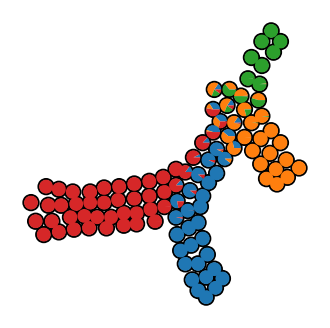

In [43]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(4,4))

# Plot cell fate probabilities as pie charts:
packages.models.tools.plot_fate_probabilities_with_pie_charts(ax, df[['x','y']], cell_fate_probabilities,
                                entropy_fade=False, frac=1, s=124, 
                                plot_order=['Fate 3', 'Fate 2', 'Fate 1', 'Fate 4'], background=120)
ax.get_legend().remove()

# Plot couplings:
transition_matrix_approx = copy.deepcopy(transition_matrix)
transition_matrix_approx[transition_matrix_approx<0.01] = 0

scale = 2
size = 50
alpha =  1

# Show the plot 
sbn.despine(bottom=True,left=True)
plt.xticks([])
plt.yticks([])


Zoom-in:

 Plotting cell nr 105/105

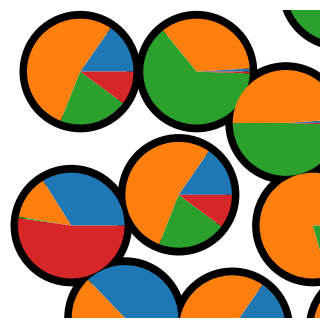

In [44]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(4,4))

packages.models.tools.plot_fate_probabilities_with_pie_charts(ax, df[['x','y']], cell_fate_probabilities,
                                entropy_fade=False, frac=1, s=124, 
                                plot_order=['Fate 3', 'Fate 2', 'Fate 1', 'Fate 4'], outline=10,background=6000)

ax.get_legend().remove()


# Show the plot 
sbn.despine(bottom=True,left=True)
plt.xticks([])
plt.yticks([])
plt.xlim([0.65,0.8])
plt.ylim([0.66,0.81])


# Supplement

In [45]:
plt.rcParams.update({'font.size': 10})

## Gauging effects of entropy regularizations on the solution:

In [46]:
epsilon_thresholds = [1e-3, 1e-2, 1e-1, 1, 1e2,1e3,1e4] #List of regularization parameter values to try

shannon_entropies = []        #List for storing entropy values for each cell
mean_shannon_entropies = []   #List for storing mean entropy values over all cells
sem_shannon_entropies = []    #List for storing standard error of the mean
cfp_list = []                 #List for storing cell fate probability estimates
costs = []                    #List for storing total transport cost in the optimal solution

epsilon_threshold = epsilon_thresholds[0] 
print(epsilon_threshold)
msot = MultistageOT(initial_cells  = df.loc[df['class'] == 0].index.tolist(),
                    terminal_cells = df.loc[df['class'] == 2].index.tolist(),
                    n_groups       = 10,  
                    epsilon        = 0.01
                    )

msot.fit(df.iloc[:,:2],
                        verbose   = True,
                        patience  = 10,
                        tolerance = 1e-4
        )

#For epsilon = 1e-3, we need to use the proximal point scheme:
msot.proximal_sinkhorn(epsilon_threshold=epsilon_threshold, patience=10)
cell_fate_probabilities_shannon = msot.cell_fate_probabilities(fates)

cfp_list.append(cell_fate_probabilities_shannon)
shannon_entropies.append(scipy.stats.entropy(cell_fate_probabilities_shannon,axis=1))
mean_shannon_entropies.append(scipy.stats.entropy(cell_fate_probabilities_shannon,axis=1).mean())
sem_shannon_entropies.append(scipy.stats.entropy(cell_fate_probabilities_shannon,axis=1).std()/np.sqrt(cell_fate_probabilities_shannon.shape[0]))
costs.append(msot.cost_of_transport())

for i in range(1,len(epsilon_thresholds)):
        epsilon_threshold = epsilon_thresholds[i]
        print(epsilon_threshold)

        msot = MultistageOT(initial_cells  = df.loc[df['class'] == 0].index.tolist(),
                        terminal_cells     = df.loc[df['class'] == 2].index.tolist(),
                        n_groups           = 10,  
                        epsilon            = epsilon_threshold
                        )

        msot.fit(df.iloc[:,:2],
                                verbose   = False,
                                patience  = 10,
                                tolerance = 1e-4
                )

      
        cell_fate_probabilities_shannon = msot.cell_fate_probabilities(fates)
        
        cfp_list.append(cell_fate_probabilities_shannon)
        shannon_entropies.append(scipy.stats.entropy(cell_fate_probabilities_shannon,axis=1))
        mean_shannon_entropies.append(scipy.stats.entropy(cell_fate_probabilities_shannon,axis=1).mean())
        sem_shannon_entropies.append(scipy.stats.entropy(cell_fate_probabilities_shannon,axis=1).std()/np.sqrt(cell_fate_probabilities_shannon.shape[0]))
        costs.append(msot.cost_of_transport())
 

0.001
 Iteration: 570 [========] Max dual step: 9.371e-07 | Infeasibility: 9.062e-05 | Elapsed time: 0:00:00.133867

Sinkhorn algorithm converged to a solution within the given tolerance (1.0000e-04) of both feasibility and max dual-variable update step.


Retrieving transport plans...
Done.
Storing dual variables...
Done.
Max absolute feasibility errors in the marginal constraints: 
  {'mu_0': 0.0, 'mu_sum': 8.467986099791602e-05, 'max_mu_t': 7.672165599481584e-05, 'mu_T': 9.061591676418068e-05}
 [Proximal Sinkhorn] Outer iterations: 1241 | Initial epsilon: 1.0000e-02 | Current epsilon: 4.0527e+00 | Total epsilon: 9.9980e-04 | Elapsed time: 0:00:15.149117
 Terminating proximal scheme.
0.01
0.1
1
100.0
1000.0
10000.0


### Mean Shannon entropy

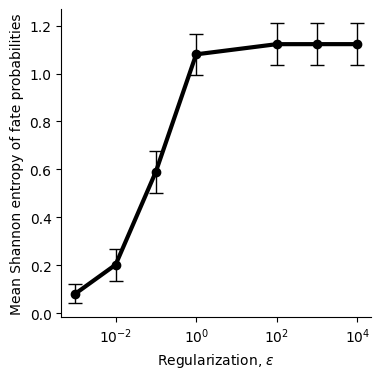

In [47]:
plt.figure(figsize=(4,4))
plt.errorbar(epsilon_thresholds, mean_shannon_entropies, yerr=1.96*np.array(sem_shannon_entropies), elinewidth=1, linewidth=3,capsize=5,marker='o', color='k')
plt.xscale('log')
sbn.despine()
plt.xlabel('Regularization, $\epsilon$')
plt.ylabel('Mean Shannon entropy of fate probabilities')

### Transport cost

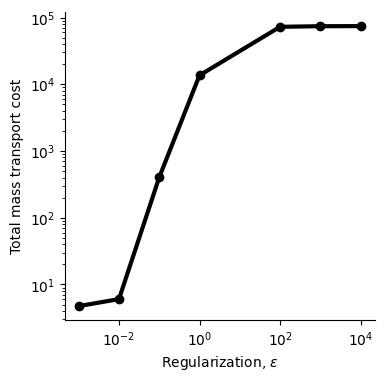

In [48]:
plt.figure(figsize=(4,4))
plt.loglog(epsilon_thresholds, costs, linewidth=3,marker='o', color='k')
sbn.despine()
plt.xlabel('Regularization, $\epsilon$')
plt.ylabel('Total mass transport cost')

### Cell fate probabilities

 Plotting cell nr 105/105

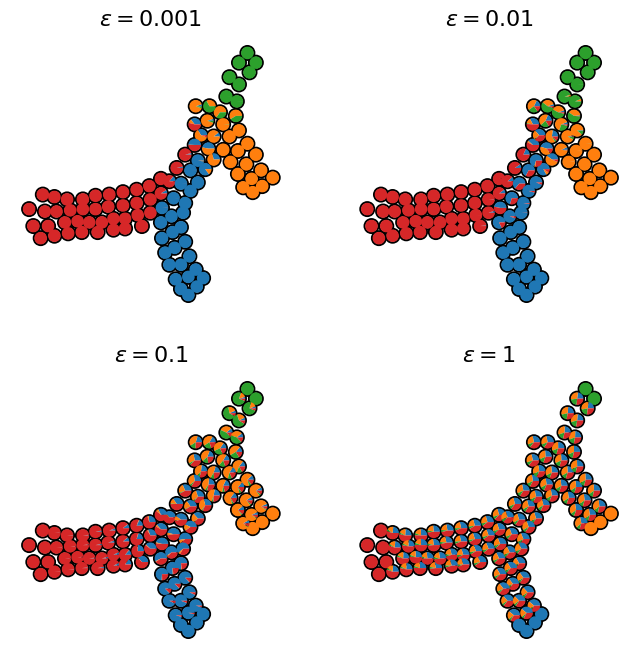

In [49]:
import copy
# Create the scatter plot

fig, ax = plt.subplots(2,2, figsize=(8,8))
axes = ax.flatten()

for i in range(len(axes)):
    ax = axes[i]
    # Plot cell fate probabilities as pie charts:
    packages.models.tools.plot_fate_probabilities_with_pie_charts(ax, df[['x','y']], cfp_list[i],
                                    entropy_fade=False, frac=1, s=124, 
                                    plot_order=['Fate 3', 'Fate 2', 'Fate 1', 'Fate 4'], background=100)
    ax.get_legend().remove()


    sbn.despine(bottom=True,left=True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("$\epsilon = {eps}$".format(eps=epsilon_thresholds[i]), fontsize=16)

### Entropy for each cell:

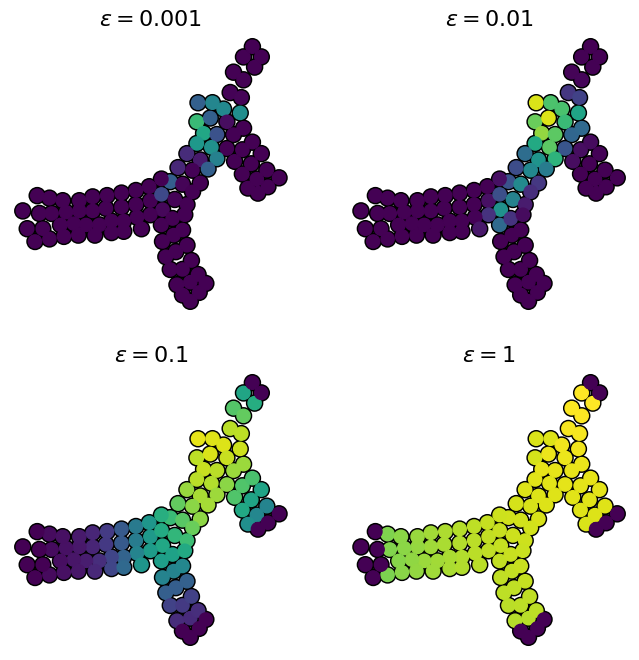

In [50]:
import copy

# Create the scatter plot
fig, ax = plt.subplots(2,2, figsize=(8,8))
axes = ax.flatten()
size = 90

for i in range(len(axes)):
    ax = axes[i]

    ax.scatter(df['x'], df['y'], s = 1.25*size, linewidth=2,facecolor='none',edgecolor='k')
    ax.scatter(df['x'], df['y'], s=size, c=shannon_entropies[i], vmin=np.min(shannon_entropies), vmax=np.max(shannon_entropies)) 

    sbn.despine(bottom=True,left=True)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_title("$\epsilon = {eps}$".format(eps=epsilon_thresholds[i]), fontsize=16)

# Outliers:

Here we apply our extended MultistageOT model with auxiliary states to the same dataset, but with three added "outlier" cells:

In [43]:
df_outliers = df.copy()
df_outliers.loc[105,:] = [0.08, 0.89, 1]
df_outliers.loc[106,:] = [0.11, 0.88, 1]
df_outliers.loc[107,:] = [0.14, 0.89, 1]

Visualize new data set:

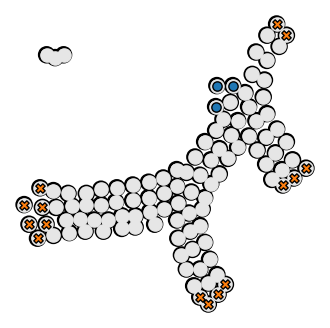

In [44]:
fig, ax = plt.subplots(figsize=(4,4))

size = 90
ax.scatter(df_outliers['x'], df_outliers['y'], s = 1.25*size, linewidth=2,facecolor='none',edgecolor='k')
ax.scatter(df_outliers['x'], df_outliers['y'], s=size, color=[0.9,0.9,0.9])
ax.scatter(df_outliers.loc[df_outliers['class'] == 0]['x'], df_outliers.loc[df_outliers['class'] == 0]['y'], s =0.5*size, color = 'tab:blue',  edgecolor='k')
ax.scatter(df_outliers.loc[df_outliers['class'] == 2]['x'], df_outliers.loc[df_outliers['class'] == 2]['y'], s=0.5*size, color='tab:orange',marker='X', edgecolor='k')



sbn.despine(left=True, bottom=True)

ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])


Adding outliers shifts the distribution of costs. Since we normalize the costs by dividing by the median cost, this will affect effective level of regularization achieved with a given $\epsilon$-parameter value. To make the solutions comparable, we will normalize the regularization parameter with the ratio of the median costs with- and without outliers.

Initialize a model to compute the median cost with outliers:

In [45]:
msot = MultistageOT(initial_cells    = df_outliers.loc[df_outliers['class'] == 0].index.tolist(),
                   terminal_cells    = df_outliers.loc[df_outliers['class'] == 2].index.tolist(),
                   n_groups             = 10,   
                   auxiliary_cell_cost  = 0.9, 
                   epsilon              = 1
                   )

msot.fit(df_outliers.iloc[:,:2],
                          verbose   = False,
                          patience  = 10,
                          tolerance = 1e-1
        )

outlier_median_cost = msot.median_cost #Get the median cost

The median cost is higher in the data set:

In [46]:
original_median_cost/outlier_median_cost

0.9038574704716084

So to get an equivalent regularization level, we will re-scale the epsilon parameter.

We first check what happens if we do not add auxiliary states:

In [47]:
msot = MultistageOT(initial_cells      = df_outliers.loc[df_outliers['class'] == 0].index.tolist(),
                    terminal_cells     = df_outliers.loc[df_outliers['class'] == 2].index.tolist(),
                    n_groups           = 10, 
                    epsilon            = 4.1667e-03*(original_median_cost/outlier_median_cost)*10
                    )

msot.fit(df_outliers.iloc[:,:2],
                          verbose   = True,
                          patience  = 10,
                          tolerance = 1e-4
        )


mu = msot.marginals()


 Iteration: 110 [========] Max dual step: 4.183e-06 | Infeasibility: 8.513e-05 | Elapsed time: 0:00:00.037189

Sinkhorn algorithm converged to a solution within the given tolerance (1.0000e-04) of both feasibility and max dual-variable update step.


Retrieving transport plans...
Done.
Storing dual variables...
Done.
Max absolute feasibility errors in the marginal constraints: 
  {'mu_0': 0.0, 'mu_sum': 8.512753331213485e-05, 'max_mu_t': 1.2002462322455165e-05, 'mu_T': 9.482465284094133e-07}


In [48]:
#mmot.proximal_sinkhorn(epsilon_threshold=0.006, patience=10)
msot.proximal_sinkhorn(epsilon_threshold=4.1667e-03*(original_median_cost/msot.median_cost), patience=10)

 [Proximal Sinkhorn] Outer iterations: 9 | Initial epsilon: 3.7661e-02 | Current epsilon: 3.7661e-02 | Total epsilon: 3.7661e-03 | Elapsed time: 0:00:01.050566
 Terminating proximal scheme.


Compute cell fates probabilities:

In [49]:
cell_fate_probabilities_outliers = msot.cell_fate_probabilities(fates)

Visualize cell fate probabilities:

 Plotting cell nr 108/108

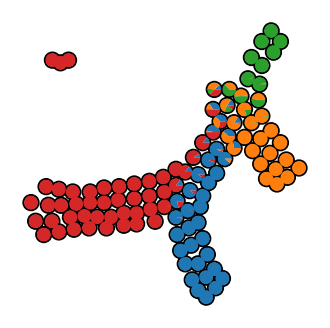

In [50]:
import copy
# Create the scatter plot

fig, ax = plt.subplots(figsize=(4,4))

# Plot cell fate probabilities as pie charts:
packages.models.tools.plot_fate_probabilities_with_pie_charts(ax, df_outliers[['x','y']], cell_fate_probabilities_outliers,
                                entropy_fade=False, frac=1, s=124, 
                                plot_order=['Fate 3', 'Fate 2', 'Fate 1', 'Fate 4'], background=120)
ax.get_legend().remove()


# Show the plot 
sbn.despine(bottom=True,left=True)
plt.xticks([])
plt.yticks([])

The outlier cells are predicted to terminate in the lower left terminal cell group (represented by the color red). We can plot the transition probabilities to get a better sense of the cell-cell affinities:

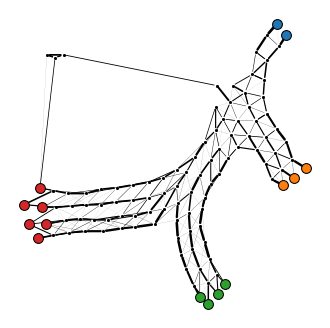

In [51]:
import copy
# Create the scatter plot

fig, ax = plt.subplots(figsize=(4,4))

transition_matrix_outliers = msot.transition_matrix()

# Plot couplings:
transition_matrix_approx = copy.deepcopy(transition_matrix_outliers)
transition_matrix_approx[transition_matrix_approx<0.01] = 0

scale = 2
size = 50
alpha =  1

df_outliers_temp = df_outliers.loc[msot.initial_cells + msot.intermediate_cells + msot.terminal_cells]

packages.models.tools.plot_couplings(ax, transition_matrix_approx, df_outliers_temp[['x','y']].values, df_outliers_temp[['x','y']].values, 
                color='k', scale=scale, alpha=alpha, scatter_size=1)

 
[ax.scatter(df.loc[fates['Fate {f}'.format(f=f+1)], 'x'], df.loc[fates['Fate {f}'.format(f=f+1)],'y'], s=50, linewidth=0.75, edgecolor='k', color=plt.get_cmap('tab10')(f)) for f in range(len(fates))]

# Show the plot 
sbn.despine(bottom=True,left=True)
plt.xticks([])
plt.yticks([])

We see a huge jump from an initial cell to the island of outliers, and then another huge jump from the outlier island to a terminal cell state. In this case, forcing all cells to take part of the main differentiation process leads to spurious trajectories.

Solve the problem again, but with auxiliary states, with a cost = 0.9 of sending mass to the auxiliary states 

In [54]:
msot = MultistageOT(initial_cells        = df_outliers.loc[df_outliers['class'] == 0].index.tolist(),
                    terminal_cells       = df_outliers.loc[df_outliers['class'] == 2].index.tolist(),
                    n_groups             = 10,   
                    auxiliary_cell_cost  = 0.9, 
                    epsilon              = 4.1667e-03*(original_median_cost/outlier_median_cost)*10
                    )

msot.fit(df_outliers.iloc[:,:2],
                          verbose   = True,
                          patience  = 10,
                          tolerance = 1e-4
        )


mu = msot.marginals()

 Iteration: 90 [========] Max dual step: 7.719e-06 | Infeasibility: 6.425e-05 | Elapsed time: 0:00:00.031750

Sinkhorn algorithm converged to a solution within the given tolerance (1.0000e-04) of both feasibility and max dual-variable update step.


Retrieving transport plans...
Done.
Storing dual variables...
Done.
Max absolute feasibility errors in the marginal constraints: 
  {'mu_0': 0.0, 'mu_sum': 0.0, 'max_mu_t': 6.425320690972569e-05, 'mu_T': 7.2230620817848035e-06}


In [55]:
msot.proximal_sinkhorn(epsilon_threshold=4.1667e-03*(original_median_cost/msot.median_cost), patience=10)

 [Proximal Sinkhorn] Outer iterations: 9 | Initial epsilon: 3.7661e-02 | Current epsilon: 3.7661e-02 | Total epsilon: 3.7661e-03 | Elapsed time: 0:00:01.026156
 Terminating proximal scheme.


(-0.001, 0.01)

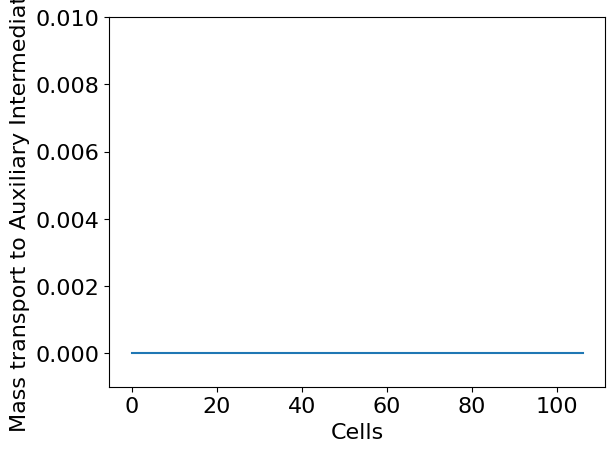

In [56]:
plt.plot(np.sum([msot.transport_plans[k][-1] for k in range(1, len(msot.transport_plans)-1)],axis=0))
plt.xlabel('Cells')
plt.ylabel('Mass transport to Auxiliary Intermediate ')
plt.ylim([-1e-3,0.01])

We see that the intermediate auxiliary state is not used throughout transport, so we do not include it in the visualization below.

### Visualize solution with the auxiliary root and terminal cell states:

We begin by computing a transition matrix (in the code below `auxiliary_initial`, `auxiliary_intermediate` and `axuiliary_terminal` refers to the three auxiliary states).

In [57]:
transition_matrix_outliers = msot.transition_matrix()

#Annotate the transition probability matrix with indices and columns:
transition_matrix_outliers_with_auxiliary_df = pd.DataFrame(transition_matrix_outliers, 
                                                            index=msot.initial_cells + ['auxiliary_initial'] + msot.intermediate_cells + ['auxiliary_intermediate'] + msot.terminal_cells + ['auxiliary_terminal'], 
                                                            columns=msot.initial_cells + ['auxiliary_initial'] + msot.intermediate_cells + ['auxiliary_intermediate'] + msot.terminal_cells + ['auxiliary_terminal'])

In [58]:
#Order data frame with outliers according to initial, intermediate and terminal states:
df_outliers = df_outliers.loc[msot.initial_cells + msot.intermediate_cells + msot.terminal_cells] 

#Add auxiliary a states to solution:
df_outliers_with_auxiliary_states = df_outliers.copy()
df_outliers_with_auxiliary_states.loc['auxiliary_initial'] = [0.2, 0.8, 0]
df_outliers_with_auxiliary_states.loc['auxiliary_terminal'] = [0.0, 1, 2]

#Since intermediate cell is not utilized in the transport, we ignore its transition probabilities since these will be spurious due to normalization
transition_matrix_outliers_with_auxiliary_no_intermediate_df = transition_matrix_outliers_with_auxiliary_df.drop(index=['auxiliary_intermediate'], columns=['auxiliary_intermediate'])

df_outliers_with_auxiliary_states = df_outliers_with_auxiliary_states.loc[transition_matrix_outliers_with_auxiliary_no_intermediate_df.index]

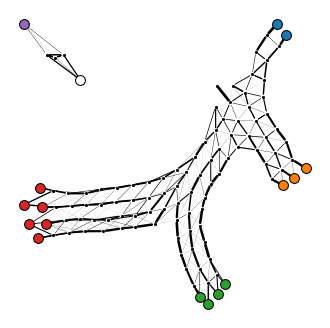

In [59]:
import copy
# Create the scatter plot

fig, ax = plt.subplots(figsize=(4,4))

# Plot couplings:
transition_matrix_approx = copy.deepcopy(transition_matrix_outliers_with_auxiliary_no_intermediate_df.values)
transition_matrix_approx[transition_matrix_approx<0.01] = 0

scale = 2
size = 50
alpha =  1

packages.models.tools.plot_couplings(ax, transition_matrix_approx, df_outliers_with_auxiliary_states[['x','y']].values, df_outliers_with_auxiliary_states[['x','y']].values, 
                color='k', scale=scale, alpha=alpha, scatter_size=1)

ax.scatter(df_outliers_with_auxiliary_states.loc['auxiliary_initial', 'x'], df_outliers_with_auxiliary_states.loc['auxiliary_initial', 'y'], s=50, linewidth=0.75, edgecolor='k', color='w')
ax.scatter(df_outliers_with_auxiliary_states.loc['auxiliary_terminal', 'x'], df_outliers_with_auxiliary_states.loc['auxiliary_terminal', 'y'], s=50, linewidth=0.75, edgecolor='k', color=plt.get_cmap('tab10')(4))

[ax.scatter(df.loc[fates['Fate {f}'.format(f=f+1)], 'x'], df.loc[fates['Fate {f}'.format(f=f+1)],'y'], s=50, linewidth=0.75, edgecolor='k', color=plt.get_cmap('tab10')(f)) for f in range(len(fates))]

# Show the plot 
sbn.despine(bottom=True,left=True)
plt.xticks([])
plt.yticks([])

We see that the island of outliers receive transitions from the auxiliary initial state (white) and sends mass to the auxiliary terminal state (purple) 

### Zoom in on auxiliary process:

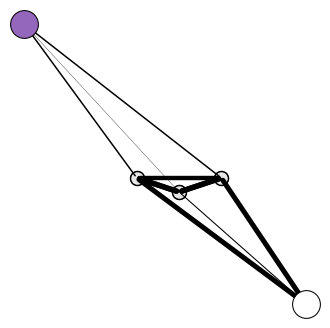

In [61]:
import copy
# Create the scatter plot

fig, ax = plt.subplots(figsize=(4,4))

# Plot couplings:
transition_matrix_approx = copy.deepcopy(transition_matrix_outliers_with_auxiliary_no_intermediate_df.loc[['auxiliary_initial', 105,106,107, 'auxiliary_terminal'],['auxiliary_initial', 105,106,107, 'auxiliary_terminal']].values)
transition_matrix_approx[transition_matrix_approx<0.01] = 0

scale = 8
alpha =  1

packages.models.tools.plot_couplings(ax, transition_matrix_approx, df_outliers_with_auxiliary_states.loc[['auxiliary_initial', 105,106,107, 'auxiliary_terminal'],['x','y']].values, df_outliers_with_auxiliary_states.loc[['auxiliary_initial', 105,106,107, 'auxiliary_terminal'],['x','y']].values, 
                color='k', scale=scale, alpha=alpha, scatter_size=100)

ax.scatter(df_outliers_with_auxiliary_states.loc['auxiliary_initial', 'x'], df_outliers_with_auxiliary_states.loc['auxiliary_initial', 'y'], s=400, linewidth=0.75, edgecolor='k', color='w')
ax.scatter(df_outliers_with_auxiliary_states.loc['auxiliary_terminal', 'x'], df_outliers_with_auxiliary_states.loc['auxiliary_terminal', 'y'], s=400, linewidth=0.75, edgecolor='k', color=plt.get_cmap('tab10')(4))

# Show the plot 
sbn.despine(bottom=True,left=True)
plt.xticks([])
plt.yticks([])

Plot transition probabilities from the auxiliary initial cell:

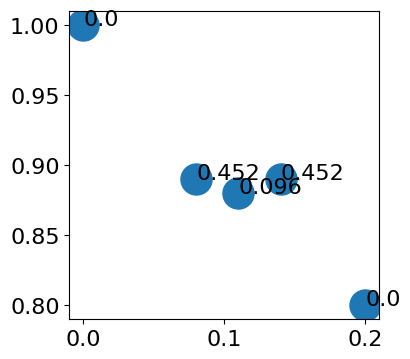

In [62]:
auxiliary_transitions = transition_matrix_outliers_with_auxiliary_no_intermediate_df.loc[['auxiliary_initial', 105,106,107, 'auxiliary_terminal'],['auxiliary_initial', 105,106,107, 'auxiliary_terminal']]
auxiliary_process_states = df_outliers_with_auxiliary_states.loc[['auxiliary_initial', 105,106,107, 'auxiliary_terminal'],['x','y']]

plt.figure(figsize=(4,4))
plt.scatter(auxiliary_process_states['x'],  auxiliary_process_states['y'], s =500)
[plt.text(auxiliary_process_states.loc[cell, 'x'],auxiliary_process_states.loc[cell, 'y'], auxiliary_transitions.loc['auxiliary_initial',cell].round(3)) for cell in auxiliary_transitions.index];

### Visualize cell fate probabilities, including the "unknown fate":

In [63]:
cell_fate_probabilities_outliers = msot.cell_fate_probabilities(fates)
cell_fate_probabilities_outliers = cell_fate_probabilities_outliers.drop(index=['auxiliary_initial','auxiliary_intermediate','auxiliary_terminal'])

Plot cell fate probabilities:

 Plotting cell nr 108/108

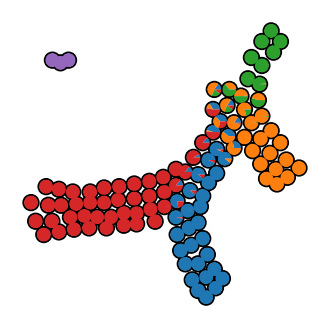

In [64]:
import copy
# Create the scatter plot

fig, ax = plt.subplots(figsize=(4,4))

# Plot cell fate probabilities as pie charts:
packages.models.tools.plot_fate_probabilities_with_pie_charts(ax, df_outliers[['x','y']], cell_fate_probabilities_outliers,
                                entropy_fade=False, frac=1, s=124, 
                                plot_order=['Fate 3', 'Fate 2', 'Fate 1', 'Fate 4', 'Fate unknown'], background=120)
ax.get_legend().remove()

# Show the plot 
sbn.despine(bottom=True,left=True)
plt.xticks([])
plt.yticks([])

Compute total variation between the probability predictions (with versus without auxiliary states):

In [65]:
tv = 0.5*np.abs(cell_fate_probabilities_outliers.loc[cell_fate_probabilities.index] - cell_fate_probabilities).iloc[:,:-1].sum(axis=1)
print("Total variation for each cell (total absolute difference in probabilities):")
tv.sort_values()

Total variation for each cell (total absolute difference in probabilities):


104    0.000000
91     0.000000
92     0.000000
93     0.000000
103    0.000000
         ...   
5      0.000021
50     0.000022
38     0.000023
1      0.000031
27     0.000033
Length: 105, dtype: float64

In [66]:
print(np.mean(tv.sort_values()))

3.3249743137233333e-06


[]

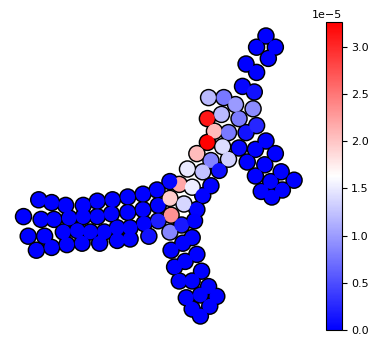

In [67]:
fig, ax = plt.subplots(figsize=(4.8,4))

size = 90
ax.scatter(df['x'], df['y'], s = 1.25*size, linewidth=2,facecolor='none',edgecolor='k')
s = ax.scatter(df['x'], df['y'], s=size,  c=tv, cmap='bwr')
cb = plt.colorbar(s)

cb.ax.tick_params(labelsize=8)
cb.ax.yaxis.get_offset_text().set_fontsize(8)

sbn.despine(left=True, bottom=True)

ax.set_xticks([])
ax.set_yticks([])

Robustness with respect to original data distribution:

In [70]:
msot = MultistageOT(initial_cells        = df.loc[df['class'] == 0].index.tolist(),
                    terminal_cells       = df.loc[df['class'] == 2].index.tolist(),
                    n_groups             = 10,  
                    epsilon              = 0.0125,
                    auxiliary_cell_cost  = 0.9
                        )

msot.fit(df.iloc[:,:2],
        verbose   = True,
        patience  = 10,
        tolerance = 1e-4
        )


mu = msot.marginals()
cell_group = msot.max_marginal_groups()

print('\n Group |', '% cells')
100*pd.Series(cell_group).value_counts()/len(msot.intermediate_cells)


 Iteration: 470 [========] Max dual step: 1.185e-06 | Infeasibility: 9.202e-05 | Elapsed time: 0:00:00.160919

Sinkhorn algorithm converged to a solution within the given tolerance (1.0000e-04) of both feasibility and max dual-variable update step.


Retrieving transport plans...
Done.
Storing dual variables...
Done.
Max absolute feasibility errors in the marginal constraints: 
  {'mu_0': 0.0, 'mu_sum': 8.418661453968301e-05, 'max_mu_t': 7.893422069937817e-05, 'mu_T': 9.202076130998549e-05}

 Group | % cells


10    14.942529
9     14.942529
3     10.344828
6     10.344828
8     10.344828
2      9.195402
7      9.195402
5      8.045977
1      6.896552
4      5.747126
Name: count, dtype: float64

In [71]:
msot.proximal_sinkhorn(epsilon_threshold=0.006, patience=10)

 [Proximal Sinkhorn] Outer iterations: 2 | Initial epsilon: 1.2500e-02 | Current epsilon: 1.2500e-02 | Total epsilon: 4.1667e-03 | Elapsed time: 0:00:00.465191
 Terminating proximal scheme.


In [72]:
cell_fate_probabilities_extended_model_original_data_distribution = msot.cell_fate_probabilities(fates).drop(['auxiliary_initial','auxiliary_intermediate', 'auxiliary_terminal'])

We check the total variation distance between the cell fate probabilities using the extended model versus the standard model on the same data distribution (we expect the predictions to be the same since we do not have outliers in the original data, so the auxiliary states should not be utilized):

In [73]:
(0.5*np.abs(cell_fate_probabilities_extended_model_original_data_distribution.iloc[:,:-1] - cell_fate_probabilities).sum(axis=1)).max()

9.501809642623157e-08

Indeed, the maximum deviation is negligible.

## Gauging effects of $Q$-cost

In [75]:
Q_list = [0.25, 0.5, 0.75, 0.95, 1.0, 1.5,  2.0, 2.75, None]
models = []

for Q in Q_list:
        print(Q)
        msot = MultistageOT(initial_cells        = df_outliers.loc[df_outliers['class'] == 0].index.tolist(),
                            terminal_cells       = df_outliers.loc[df_outliers['class'] == 2].index.tolist(),
                            n_groups             = 10,   
                            auxiliary_cell_cost  = Q, 
                            epsilon              = 4.1667e-03*(original_median_cost/outlier_median_cost)*10
                            )

        msot.fit(df_outliers.iloc[:,:2],
                                verbose   = True,
                                patience  = 10,
                                tolerance = 1e-4
                )

        msot.proximal_sinkhorn(epsilon_threshold=4.1667e-03*(original_median_cost/msot.median_cost), patience=10)
        models.append(msot)

0.25
 Iteration: 80 [========] Max dual step: 1.585e-06 | Infeasibility: 4.571e-05 | Elapsed time: 0:00:00.027571

Sinkhorn algorithm converged to a solution within the given tolerance (1.0000e-04) of both feasibility and max dual-variable update step.


Retrieving transport plans...
Done.
Storing dual variables...
Done.
Max absolute feasibility errors in the marginal constraints: 
  {'mu_0': 0.0, 'mu_sum': 0.0, 'max_mu_t': 4.5707800722105674e-05, 'mu_T': 0.0}
 [Proximal Sinkhorn] Outer iterations: 9 | Initial epsilon: 3.7661e-02 | Current epsilon: 3.7661e-02 | Total epsilon: 3.7661e-03 | Elapsed time: 0:00:00.980772
 Terminating proximal scheme.
0.5
 Iteration: 90 [========] Max dual step: 4.652e-06 | Infeasibility: 4.796e-05 | Elapsed time: 0:00:00.026924

Sinkhorn algorithm converged to a solution within the given tolerance (1.0000e-04) of both feasibility and max dual-variable update step.


Retrieving transport plans...
Done.
Storing dual variables...
Done.
Max absolute feasibilit

Plotting cell fate probabilities

 Plotting cell nr 108/108

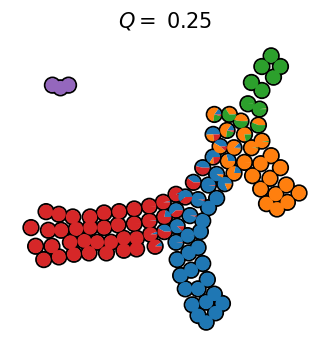

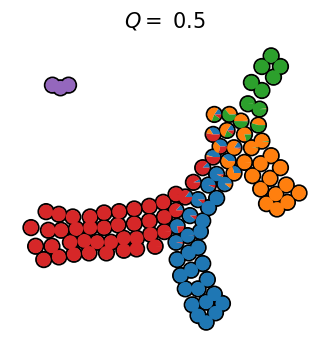

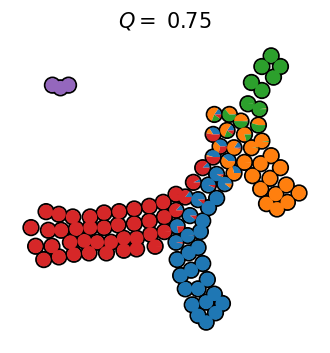

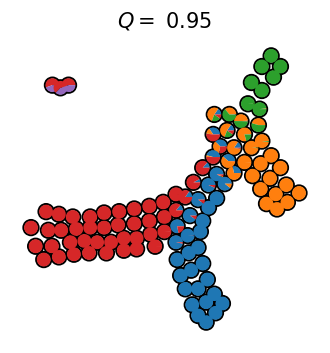

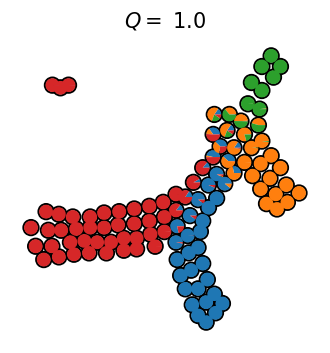

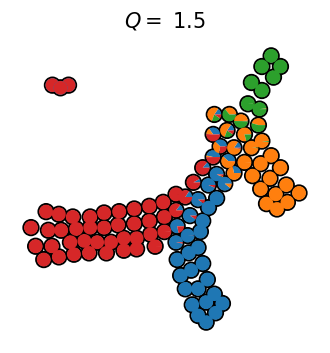

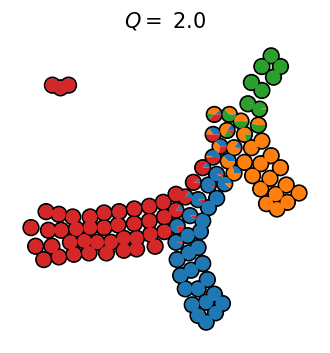

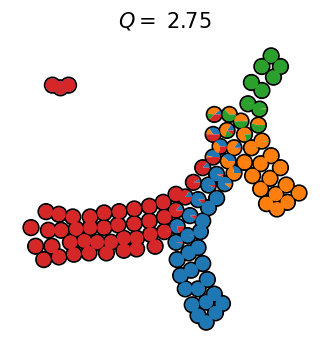

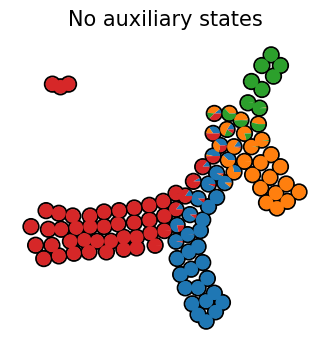

In [76]:
for i in range(len(models)):
    model = models[i]
    Q = Q_list[i]
    cell_fate_probabilities_outliers = model.cell_fate_probabilities(fates)
    # Create the scatter plot

    fig, ax = plt.subplots(figsize=(4,4))

    # Plot cell fate probabilities as pie charts:
    if Q is not None:
        packages.models.tools.plot_fate_probabilities_with_pie_charts(ax, df_outliers[['x','y']], cell_fate_probabilities_outliers,
                                    entropy_fade=False, frac=1, s=124, 
                                    plot_order=['Fate 3', 'Fate 2', 'Fate 1', 'Fate 4', 'Fate unknown'], background=120)
    else:
        packages.models.tools.plot_fate_probabilities_with_pie_charts(ax, df_outliers[['x','y']], cell_fate_probabilities_outliers,
                                    entropy_fade=False, frac=1, s=124, 
                                    plot_order=['Fate 3', 'Fate 2', 'Fate 1', 'Fate 4'], background=120)

    ax.get_legend().remove()

    # Show the plot 
    sbn.despine(bottom=True,left=True)
    plt.xticks([])
    plt.yticks([])
    if Q is not None:
        ax.set_title("$Q=$ "+str(Q), fontsize=15)
    else:
        ax.set_title("No auxiliary states", fontsize=15)

Plotting TV with respect to the solution without auxiliary states

Max TV: Q=0.25, 0.9999914294024405
Max TV: Q=0.5, 1.0000000000000004
Max TV: Q=0.75, 1.0000000000000002
Max TV: Q=0.95, 0.44593920441594814
Max TV: Q=1.0, 0.27300561132756723
Max TV: Q=1.5, 0.27301415025286796
Max TV: Q=2.0, 9.677268569818764e-09
Max TV: Q=2.75, 4.996003615595342e-16


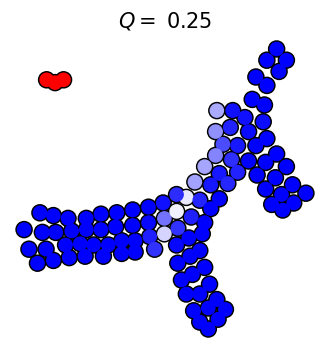

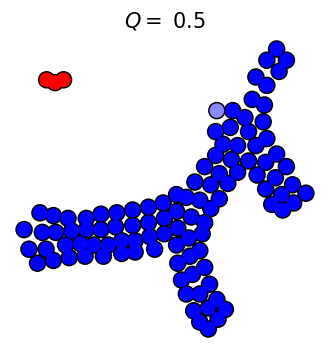

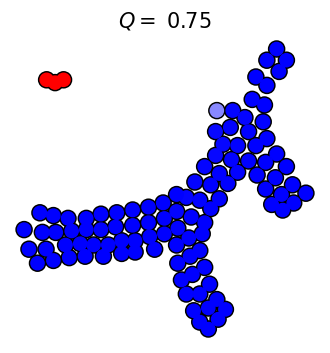

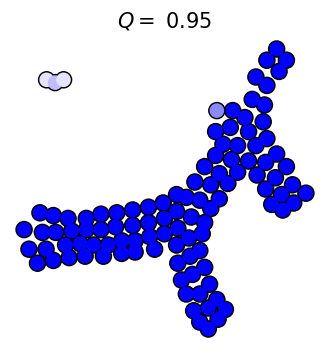

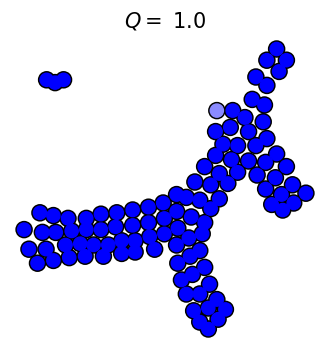

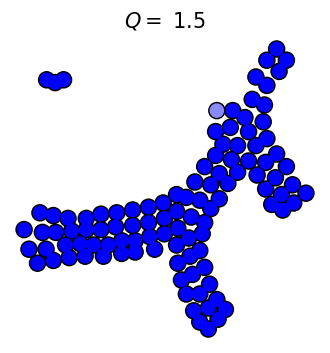

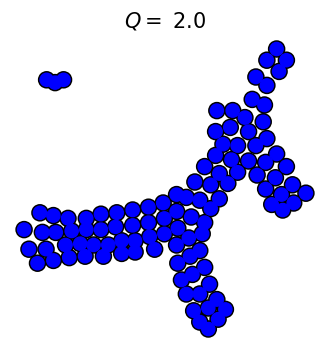

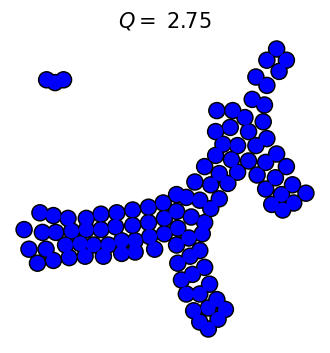

In [77]:
cell_fate_probabilities_no_auxiliary_states = models[-1].cell_fate_probabilities(fates)
cell_fate_probabilities_no_auxiliary_states['Fate unknown'] = 0
for i in range(len(models)-1):
    model = models[i]
    Q = Q_list[i]
    cell_fate_probabilities_outliers = model.cell_fate_probabilities(fates)
    tv = 0.5*np.abs(cell_fate_probabilities_outliers.loc[cell_fate_probabilities_no_auxiliary_states.index] - cell_fate_probabilities_no_auxiliary_states).sum(axis=1)
    print("Max TV: Q="+str(Q)+", "+str(tv.max()))
    fig, ax = plt.subplots(figsize=(4,4))
    size = 90
    ax.scatter(df_outliers.loc[tv.index, 'x'], df_outliers.loc[tv.index,'y'], s = 1.25*size, linewidth=2,facecolor='none',edgecolor='k')
    s = ax.scatter(df_outliers.loc[tv.index,'x'], df_outliers.loc[tv.index,'y'], s=size,  c=tv, vmin=0, vmax=1,cmap='bwr')

    sbn.despine(left=True, bottom=True)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("$Q=$ "+str(Q), fontsize=15)